# Imports

In [ ]:
# Standard libraries imports

import tensorflow as tf
from tensorflow.keras import layers

# Hardware Detection

In [ ]:
# Detect hardware
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select an appropriate distribution strategy
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


# Configs

In [ ]:
class config:

  MAXLEN = 512 # maximum length of sequence

  # model configs
  BATCH_SIZE_PER_REPLICA = 256 # batch size per replica
  BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync # global batch size
  EPOCHS = 100 # number of epochs
  LEARNING_RATE = 1E-4 # learning rate
  LEARTING_RATE_REDUCTION_PATIENCE = 10 # number of epochs to weight before lowering LR
  LEARTING_RATE_REDUCTION_FACTOR = 0.2 # LR lowering factor
  BUFFER = 1024 # buffer size for shuffling the training set
  EMBEDDING_SIZE = 256 # embedding size
  NUM_HEADS = 8 # number of heads
  NUM_BLOCKS = 4 # number of encoder blocks
  KEY_DIM = 64 # dimesion of the key, value, and query
  DROPOUT = 0.0 # dopout rate
  SKIP_RATIO = 0.0 # skip connection ratio

# Models

## Vanilla Transformer Model

In [ ]:
with strategy.scope():
  # embedding layer that maps each input character index into a vector of the specified length
  # in the config class
  embedding_layer = layers.Embedding(input_dim=len(chars)+3, output_dim=config.EMBEDDING_SIZE, input_length=config.MAXLEN, mask_zero=True)
  # use another trainable embedding layer to learn positional encoding 
  pos_encoding = layers.Embedding(input_dim=config.MAXLEN+1, output_dim=config.EMBEDDING_SIZE, input_length=config.MAXLEN, mask_zero=False)

In [ ]:
def main_encoder_block(inputs, num_heads=8, key_dim=64, dropout=0.0, linear_shape=128):
  # multi-head self-attention layer
  self_att = layers.MultiHeadAttention(num_heads=num_heads,
                                       key_dim=key_dim, 
                                       dropout=dropout)(inputs, inputs)
  # add & norm
  add = layers.Add(name='encoder_add')([inputs, self_att])
  norm = layers.LayerNormalization()(add)

  # feed-forward network
  ff = layers.Dense(linear_shape, activation='gelu')(norm)
  ff = layers.Dense(inputs.shape[-1], activation='linear')(ff)
  
  # add & norm
  add = layers.Add()([norm, ff])
  norm = layers.LayerNormalization()(add)
  return norm

In [ ]:
def encoder_model(inputs):
  # embed input sequences
  embed = embedding_layer(inputs)
  # trainable positional encoding
  pos_encod = pos_encoding(tf.range(config.MAXLEN))
  # add pos_encod to embeddings
  embed = embed + pos_encod

  main_encoder_output = main_encoder_block(embed)

  return main_encoder_output

In [ ]:
def main_decoder_block(inputs, main_encoder_output, 
                       attention_mask, num_heads=8, key_dim=64, 
                       dropout=0.0, linear_shape=128):
  # multi-head masked self-attention layer
  self_att = layers.MultiHeadAttention(num_heads=num_heads,
                                       key_dim=key_dim, 
                                       dropout=dropout)(inputs, inputs, attention_mask=attention_mask)
  # feed-forward network
  ff = layers.Dense(linear_shape, activation='gelu')(self_att)
  ff = layers.Dense(inputs.shape[-1], activation='linear')(ff)
  # add & norm
  add = layers.Add()([self_att, ff])
  self_att_output = layers.LayerNormalization()(add)

  # Encoder-Decoder Attention
  enc_dec_att = layers.MultiHeadAttention(num_heads=num_heads,
                                          key_dim=key_dim,
                                          dropout=dropout)(query=self_att_output, value=main_encoder_output, key=main_encoder_output)

  # add & norm
  add = layers.Add()([self_att_output, enc_dec_att])
  norm = layers.LayerNormalization()(add)
 
  # feed-forward network
  ff = layers.Dense(linear_shape, activation='gelu')(norm)
  ff = layers.Dense(inputs.shape[-1], activation='linear')(ff)
  
  # add & norm
  add = layers.Add()([norm, ff])
  norm = layers.LayerNormalization()(add)
  return norm

In [ ]:
def decoder_model(inputs, main_encoder_output, attention_mask):
  # embed input sequences
  embed = embedding_layer(inputs)
  # trainable positional encoding
  pos_encod = pos_encoding(tf.range(config.MAXLEN))
  # add pos_encod to embeddings
  embed = embed + pos_encod

  main_decoder_output = main_decoder_block(embed, main_encoder_output, attention_mask)

  return main_decoder_output

In [ ]:
def final_decoder_output(enc_inputs, dec_inputs, attention_mask):

  x = encoder_model(enc_inputs)
  x = decoder_model(dec_inputs, x, attention_mask)
  x = layers.GlobalAveragePooling1D()(x)
  main_dec_output = layers.Dense(len(chars)+3, activation='softmax')(x)
  return main_dec_output

In [ ]:
def encoder_decoder_model():
  # put it all together
  enc_inputs = layers.Input(shape=(config.MAXLEN,), name='enc_input')
  dec_inputs = layers.Input(shape=(config.MAXLEN,), name='dec_input')
  attention_mask = layers.Input(shape=(config.NUM_HEADS, config.MAXLEN, config.MAXLEN,), name='att_mask')

  main_dec_output = final_decoder_output(enc_inputs, dec_inputs, attention_mask)

  model = tf.keras.Model(inputs=[enc_inputs, dec_inputs, attention_mask], outputs=main_dec_output)
  return model

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate the model and print the summary
model = encoder_decoder_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dec_input (InputLayer)         [(None, 17)]         0           []                               
                                                                                                  
 enc_input (InputLayer)         [(None, 17)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 17, 256)      10496       ['enc_input[0][0]',              
                                                                  'dec_input[0][0]']              
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 17, 256)     0           ['embedding[0][0]']          

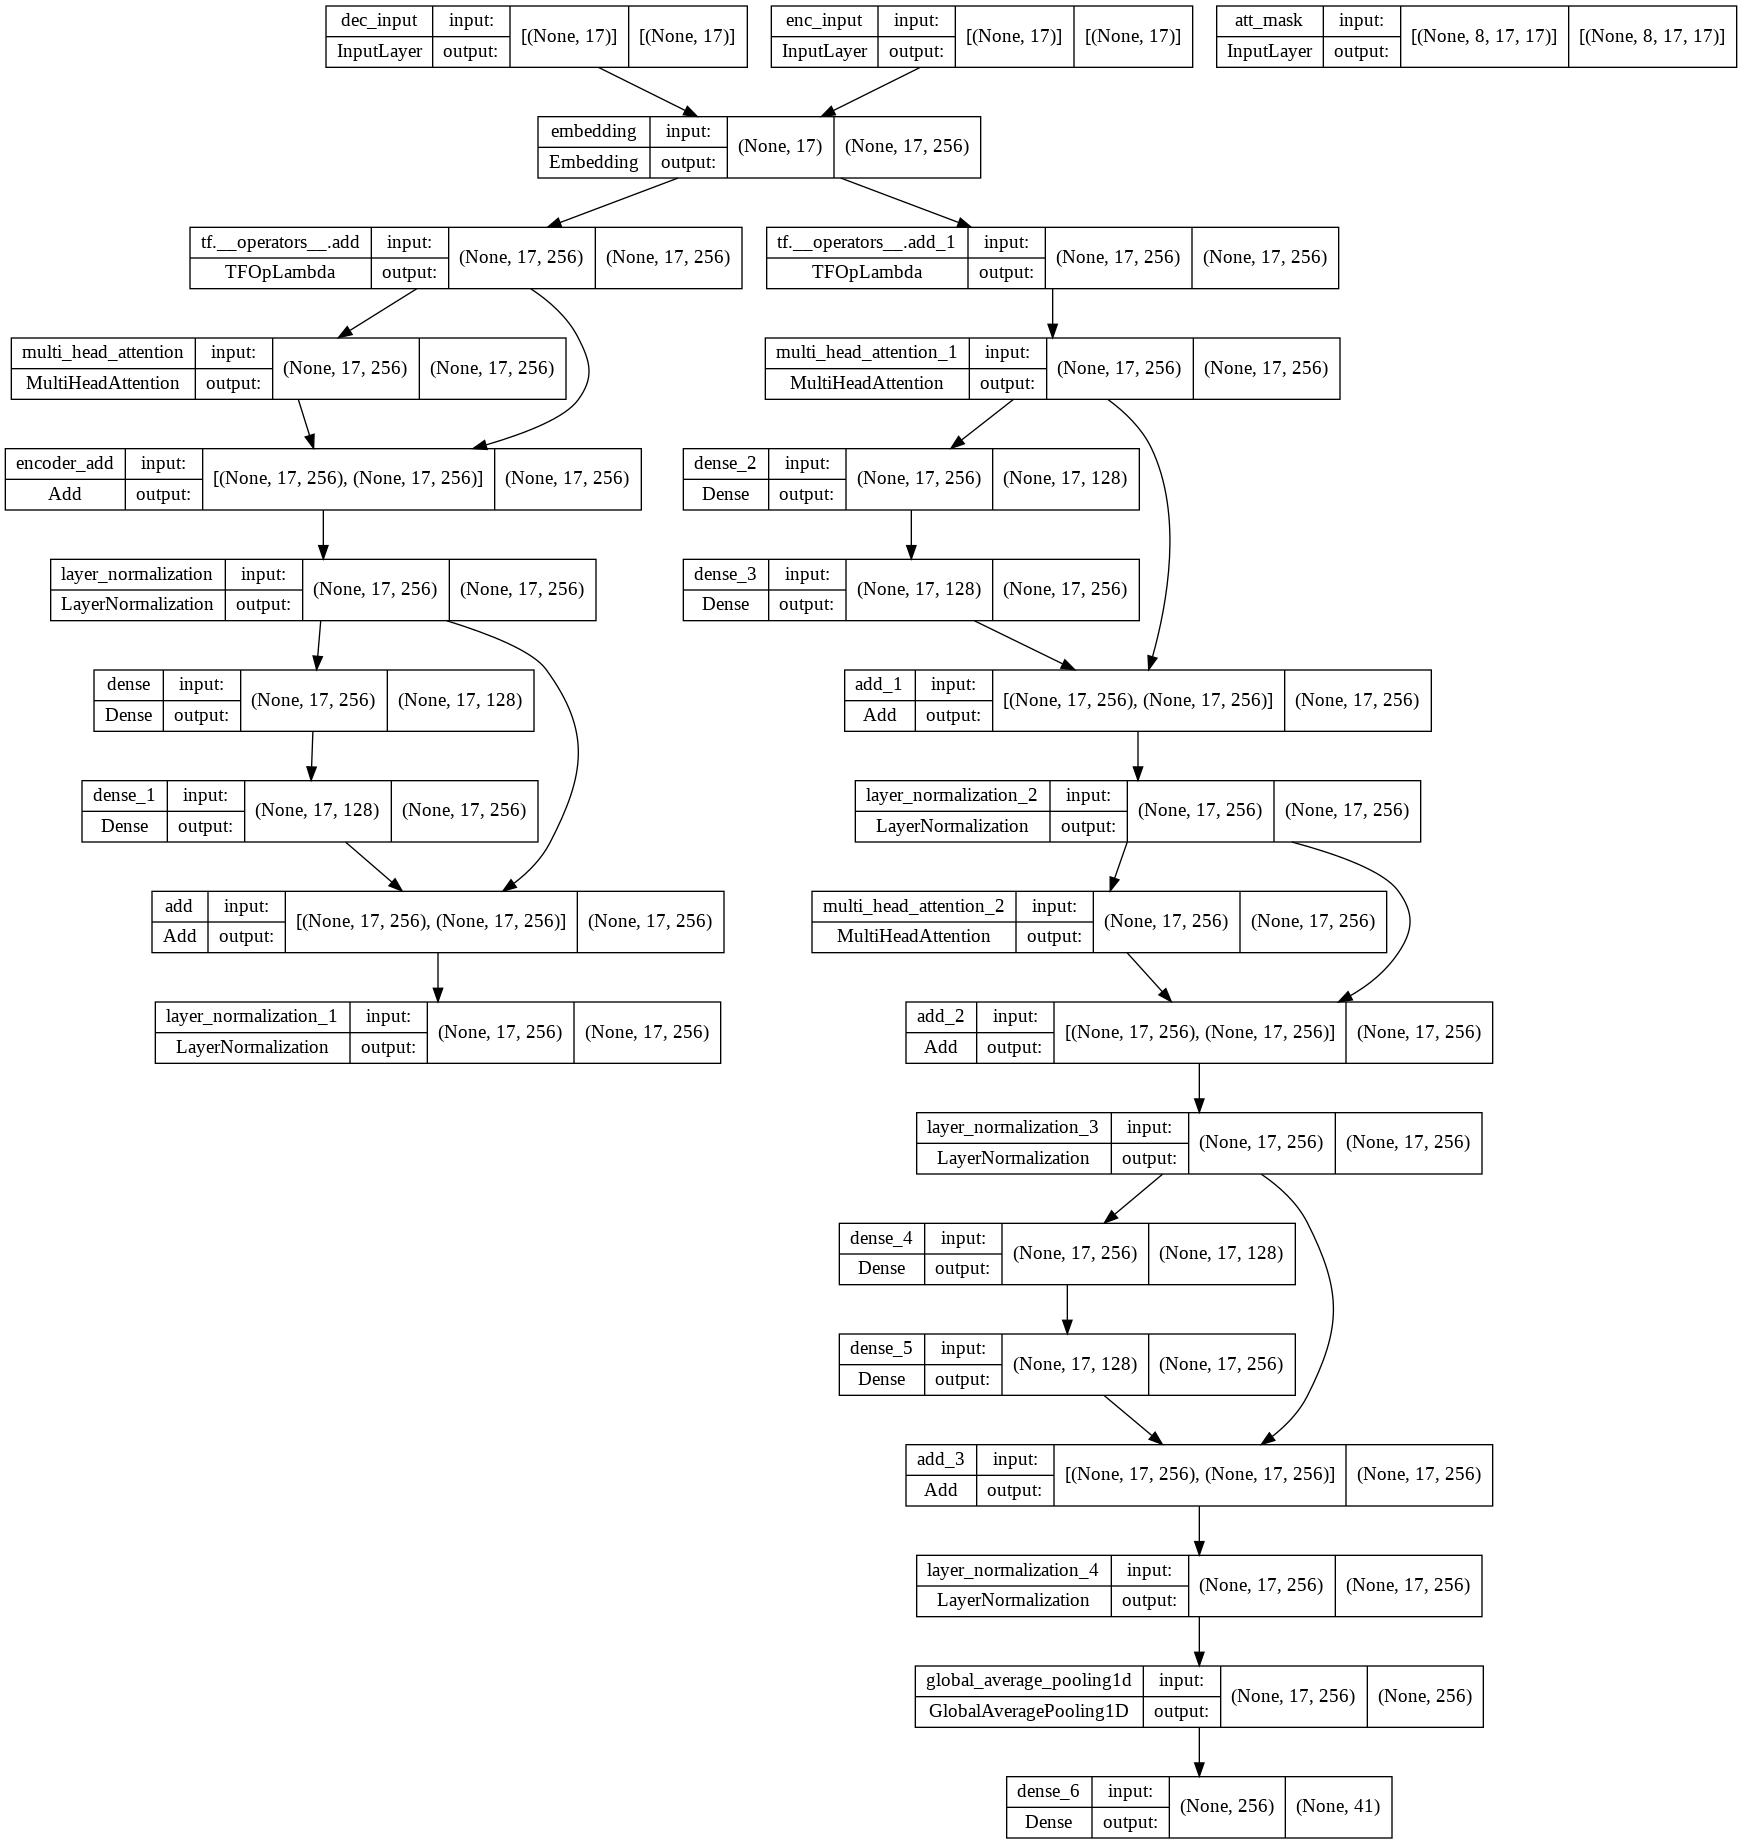

In [ ]:
# plot the model
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

# Custom Training

## GPU

In [ ]:
# construct attention masks list
# for each position there a mask that prevents the model from 
# see current and next positions
attention_masks = []
for i in range(1, config.MAXLEN+1):
  # Arabic masking starts from right to left
  attention_mask = [0] * (config.MAXLEN - i) + [1] * i
  attention_masks.append(attention_mask)

In [ ]:
# provide automatic class weights based on the inverse frequency 
# of each token, the more frequent, the less weight
total_num_labels = np.array(dec_indexed_text_train_labels).size
auto_weight_dict = dict()
for i in range(len(chars)+3):
  num_class_examples = (np.array(dec_indexed_text_train_labels) == i).sum()
  if num_class_examples != 0:
    auto_weight_dict[i] = total_num_labels / num_class_examples
  else:
    auto_weight_dict[i] = 0.1

auto_weight_dict[0] = 0.0 # give 'p' zero weight
auto_weight_dict

{0: 0.0,
 1: 17.0,
 2: 0.1,
 3: 15.992474129821261,
 4: 0.1,
 5: 95.50561797752809,
 6: 26.27511591962906,
 7: 459.4594594594595,
 8: 739.1304347826087,
 9: 184.7826086956522,
 10: 141.66666666666666,
 11: 354.1666666666667,
 12: 103.03030303030303,
 13: 1000.0,
 14: 54.83870967741935,
 15: 377.77777777777777,
 16: 112.58278145695364,
 17: 250.0,
 18: 204.81927710843374,
 19: 404.76190476190476,
 20: 204.81927710843374,
 21: 1133.3333333333333,
 22: 97.70114942528735,
 23: 653.8461538461538,
 24: 134.9206349206349,
 25: 107.59493670886076,
 26: 215.18987341772151,
 27: 76.57657657657657,
 28: 41.16222760290557,
 29: 50.89820359281437,
 30: 229.72972972972974,
 31: 66.40625,
 32: 41.46341463414634,
 33: 447.36842105263156,
 34: 1214.2857142857142,
 35: 118.88111888111888,
 36: 1416.6666666666667,
 37: 500.0,
 38: 340.0,
 39: 2125.0,
 40: 0.1}

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))

# initialize the best accuracy at - infinity
best_result = -np.inf
# initialize the epoch of the best result as 0
epoch_of_best_result = 0
# initialize a variable for the current learning rate
current_learning = config.LEARNING_RATE
# for each epoch iterate over the whole training and validation sets
for epoch in range(config.EPOCHS):
  print(f'Epoch: {epoch+1}/{config.EPOCHS}')
  # iterate over the training dataset
  for batch in tqdm(train_ds, total=len(train_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # initialize losses and accuracies list
    losses = []
    accs = []
    top_accs = []
    # sequencially predict the label (actual previous token as input)
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # train on each batch and pass the class weights
      train_results = model.train_on_batch(x=(enc_inputs, dec_inputs, current_att_mask), y=labels[:, -(i+1)], 
                           class_weight=auto_weight_dict, reset_metrics=True, return_dict=True)
      # append the loss value
      losses.append(train_results['loss'])
      # append the accuracy value
      accs.append(train_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(train_results['top_k_acc'])
  print('Train loss:', np.mean(losses), 'Train accuracy', np.mean(accs), 'Train top 5 accuracy', np.mean(top_accs))

  # initialize losses and accuracies list
  losses = []
  accs = []
  top_accs = []
  # iterate over the validation dataset
  for batch in tqdm(valid_ds, total=len(valid_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # create a NumPy array to save the predictions of the previous tokens
    # it is initialized with ones where the model will see 1 in the first 
    # pass which represents the special starting "s" token
    full_sequence_preds = np.ones((num_examples, config.MAXLEN))
    # sequencially predict the label (predicted previous token as input (Auto-Regression))
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # evaluate on each batch
      valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=True, return_dict=True)
      # predict the tokens of the current position
      preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
      # take the argmax value which represents the index of the highest prob character
      current_preds = np.argmax(preds, axis=-1)
      # populate the current position with the predicted values which will be used in the next 
      # pass as a decoder input
      full_sequence_preds[:, -(i+1)] = current_preds # populate the column of the current timestep with the predicitons
        
      # append the loss value  
      losses.append(valid_results['loss'])
      # append the accuracy value
      accs.append(valid_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(valid_results['top_k_acc'])
  print('Valid loss:', np.mean(losses), 'Valid accuracy', np.mean(accs), 'Valid top 5 accuracy', np.mean(top_accs))

  mean_acc = np.mean(accs)
  # save the weights of the best model based on the validation accuracy
  # lower the LR a factor defined in the config class if the validation accuracy 
  # does not improve for the stated patience in the config class
  if mean_acc > best_result:
    best_result = mean_acc
    epoch_of_best_result = epoch
    print('Saving best model wieghts,', 'Accuracy:', mean_acc)
    model.save_weights('best_full_model_weights.h5')
  else:
    print("Accuracy didn't improve from:", best_result)
  if epoch - epoch_of_best_result == config.LEARTING_RATE_REDUCTION_PATIENCE:
    current_learning = current_learning * config.LEARTING_RATE_REDUCTION_FACTOR
    print("model didn't improve for 10 epochs---->", f"lower learning rate to {current_learning}")
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tf.keras.optimizers.Adam(learning_rate=current_learning))  

    

Epoch: 1/100


100%|██████████| 4/4 [00:12<00:00,  3.11s/it]


Train loss: 129.61708155362044 Train accuracy 0.006845841869054472 Train top 5 accuracy 0.09837728253949214


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.211446734035716 Valid accuracy 0.028993143645279548 Valid top 5 accuracy 0.10852191049386473
Saving best model wieghts, Accuracy: 0.028993143645279548
Epoch: 2/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 122.23489596475574 Train accuracy 0.05070993980831083 Train top 5 accuracy 0.1397058818872799


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.147175291005303 Valid accuracy 0.05062410169664551 Valid top 5 accuracy 0.13644539137535236
Saving best model wieghts, Accuracy: 0.05062410169664551
Epoch: 3/100


100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Train loss: 103.81377710402012 Train accuracy 0.07378296063774649 Train top 5 accuracy 0.20258620860712492


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.100918257937712 Valid accuracy 0.08317222380462815 Valid top 5 accuracy 0.18812330866999485
Saving best model wieghts, Accuracy: 0.08317222380462815
Epoch: 4/100


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Train loss: 77.88228242669035 Train accuracy 0.08113590280032333 Train top 5 accuracy 0.23504056954098976


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


Valid loss: 4.859092649291544 Valid accuracy 0.05282021226251826 Valid top 5 accuracy 0.20437426054302385
Accuracy didn't improve from: 0.08317222380462815
Epoch: 5/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 75.11551919579506 Train accuracy 0.0824036523425842 Train top 5 accuracy 0.2030933056410183


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 4.931502114324009 Valid accuracy 0.0717756931176957 Valid top 5 accuracy 0.2264515711542438
Accuracy didn't improve from: 0.08317222380462815
Epoch: 6/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train loss: 46.16407720656956 Train accuracy 0.17469574064564178 Train top 5 accuracy 0.3466024350320153


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.281806872171514 Valid accuracy 0.09395468859549831 Valid top 5 accuracy 0.23839614036328652
Saving best model wieghts, Accuracy: 0.09395468859549831
Epoch: 7/100


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Train loss: 47.73637744389913 Train accuracy 0.15339756551582148 Train top 5 accuracy 0.328600407934145


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.479375930393443 Valid accuracy 0.1470667465644724 Valid top 5 accuracy 0.31168520636856556
Saving best model wieghts, Accuracy: 0.1470667465644724
Epoch: 8/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 35.10972621116568 Train accuracy 0.20588235313291936 Train top 5 accuracy 0.3587728208204841


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


Valid loss: 5.257417389575173 Valid accuracy 0.13791254743495407 Valid top 5 accuracy 0.3086095953031498
Accuracy didn't improve from: 0.1470667465644724
Epoch: 9/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 30.228646958356393 Train accuracy 0.1982758639873389 Train top 5 accuracy 0.3377281948650146


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Valid loss: 5.308818964397206 Valid accuracy 0.17520020080401616 Valid top 5 accuracy 0.3407998430159162
Saving best model wieghts, Accuracy: 0.17520020080401616
Epoch: 10/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 27.551278695464134 Train accuracy 0.21247464730678237 Train top 5 accuracy 0.3714503045193851


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Valid loss: 5.287048900828642 Valid accuracy 0.15258805431863842 Valid top 5 accuracy 0.3284089209183174
Accuracy didn't improve from: 0.17520020080401616
Epoch: 11/100


100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


Train loss: 25.043356443152707 Train accuracy 0.23909736282246954 Train top 5 accuracy 0.38032454205676913


100%|██████████| 2/2 [00:05<00:00,  2.57s/it]


Valid loss: 5.706112689831677 Valid accuracy 0.1473850050174138 Valid top 5 accuracy 0.3034395596341175
Accuracy didn't improve from: 0.17520020080401616
Epoch: 12/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 26.086050329401214 Train accuracy 0.22413793173344695 Train top 5 accuracy 0.3653651085572646


100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


Valid loss: 5.136218610055306 Valid accuracy 0.18183342728982954 Valid top 5 accuracy 0.334533733808819
Saving best model wieghts, Accuracy: 0.18183342728982954
Epoch: 13/100


100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Train loss: 22.47316186962759 Train accuracy 0.24949290417134762 Train top 5 accuracy 0.3732251555330175


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.495766367982416 Valid accuracy 0.15415029107209513 Valid top 5 accuracy 0.32336037792265415
Accuracy didn't improve from: 0.18183342728982954
Epoch: 14/100


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Train loss: 16.51333633130964 Train accuracy 0.2662271794534343 Train top 5 accuracy 0.3828600377447027


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Valid loss: 5.534009081475875 Valid accuracy 0.2159015274442294 Valid top 5 accuracy 0.355429133400321
Saving best model wieghts, Accuracy: 0.2159015274442294
Epoch: 15/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 20.967137559371835 Train accuracy 0.22185598278199048 Train top 5 accuracy 0.3468559844255009


100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


Valid loss: 5.266834804240395 Valid accuracy 0.1956954655401847 Valid top 5 accuracy 0.35159551505656805
Accuracy didn't improve from: 0.2159015274442294
Epoch: 16/100


100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Train loss: 21.00959561589886 Train accuracy 0.24594320323975646 Train top 5 accuracy 0.35446247269454245


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


Valid loss: 5.348679654738483 Valid accuracy 0.1815151710282354 Valid top 5 accuracy 0.3410982931142344
Accuracy didn't improve from: 0.2159015274442294
Epoch: 17/100


100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Train loss: 21.809113715063123 Train accuracy 0.24188640973914197 Train top 5 accuracy 0.36561866320998354


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.74874906066586 Valid accuracy 0.19554756209254265 Valid top 5 accuracy 0.3459857270559844
Accuracy didn't improve from: 0.2159015274442294
Epoch: 18/100


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Train loss: 14.508469889707426 Train accuracy 0.2634381357963909 Train top 5 accuracy 0.3777890481219134


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Valid loss: 5.343127337448737 Valid accuracy 0.23284842008176973 Valid top 5 accuracy 0.35415213785189037
Saving best model wieghts, Accuracy: 0.23284842008176973
Epoch: 19/100


100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Train loss: 14.040101481272893 Train accuracy 0.2659736333743614 Train top 5 accuracy 0.38083164259681807


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.416502239073024 Valid accuracy 0.22806927287841544 Valid top 5 accuracy 0.3512112272574621
Accuracy didn't improve from: 0.23284842008176973
Epoch: 20/100


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Train loss: 17.91259949435206 Train accuracy 0.2715517219484729 Train top 5 accuracy 0.36409736860214786


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.1912573768812065 Valid accuracy 0.20172519488807986 Valid top 5 accuracy 0.352563493172912
Accuracy didn't improve from: 0.23284842008176973
Epoch: 21/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 12.557227382765097 Train accuracy 0.2773833709549816 Train top 5 accuracy 0.38083164259681807


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.236115116406889 Valid accuracy 0.2522964728448321 Valid top 5 accuracy 0.36339217829791937
Saving best model wieghts, Accuracy: 0.2522964728448321
Epoch: 22/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 12.340770491782356 Train accuracy 0.2811866124324939 Train top 5 accuracy 0.38717038269319076


100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


Valid loss: 5.478725868989439 Valid accuracy 0.2323399993645794 Valid top 5 accuracy 0.36633309064542546
Accuracy didn't improve from: 0.2522964728448321
Epoch: 23/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 13.153419399524436 Train accuracy 0.2865111582145533 Train top 5 accuracy 0.38894523370682316


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Valid loss: 5.494605485130759 Valid accuracy 0.21701080625986352 Valid top 5 accuracy 0.3585047426030916
Accuracy didn't improve from: 0.2522964728448321
Epoch: 24/100


100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Train loss: 12.537355423631038 Train accuracy 0.2900608532295069 Train top 5 accuracy 0.38057808969717694


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.5115633554318375 Valid accuracy 0.22020791098475456 Valid top 5 accuracy 0.35439512593781247
Accuracy didn't improve from: 0.2522964728448321
Epoch: 25/100


100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Train loss: 10.283744369359578 Train accuracy 0.3118661264888942 Train top 5 accuracy 0.386916835052783


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Valid loss: 5.604167621801881 Valid accuracy 0.2377028394052211 Valid top 5 accuracy 0.355996977099601
Accuracy didn't improve from: 0.2522964728448321
Epoch: 26/100


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Train loss: 9.839878531063304 Train accuracy 0.3174442219109658 Train top 5 accuracy 0.3909736253485522


100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


Valid loss: 5.765307075837079 Valid accuracy 0.2204244843519786 Valid top 5 accuracy 0.35315114928080754
Accuracy didn't improve from: 0.2522964728448321
Epoch: 27/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 9.133990880321054 Train accuracy 0.3159229196334148 Train top 5 accuracy 0.3909736253485522


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


Valid loss: 5.524395225679173 Valid accuracy 0.24400196596980095 Valid top 5 accuracy 0.36351367064258633
Accuracy didn't improve from: 0.2522964728448321
Epoch: 28/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 12.471586691544337 Train accuracy 0.2771298173979363 Train top 5 accuracy 0.38108519374338146


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Valid loss: 5.580502145430621 Valid accuracy 0.23122411714318922 Valid top 5 accuracy 0.3608976188389694
Accuracy didn't improve from: 0.2522964728448321
Epoch: 29/100


100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Train loss: 8.049918797524537 Train accuracy 0.320233270060271 Train top 5 accuracy 0.39072008121429996


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


Valid loss: 5.73075414843419 Valid accuracy 0.2666761745863101 Valid top 5 accuracy 0.3613439713988234
Saving best model wieghts, Accuracy: 0.2666761745863101
Epoch: 30/100


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Train loss: 12.108417851959958 Train accuracy 0.2740872194442679 Train top 5 accuracy 0.3724645026411642


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.759123079917011 Valid accuracy 0.23868138123961055 Valid top 5 accuracy 0.3584981409504133
Accuracy didn't improve from: 0.2666761745863101
Epoch: 31/100


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Train loss: 11.593601079767241 Train accuracy 0.3004563876756412 Train top 5 accuracy 0.386916835052783


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.471391256241238 Valid accuracy 0.24684779630864367 Valid top 5 accuracy 0.36357573496506496
Accuracy didn't improve from: 0.2666761745863101
Epoch: 32/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 12.66630586412023 Train accuracy 0.2996957428917727 Train top 5 accuracy 0.37702839818837885


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


Valid loss: 5.733539839001263 Valid accuracy 0.2225453217020806 Valid top 5 accuracy 0.3540636636316776
Accuracy didn't improve from: 0.2666761745863101
Epoch: 33/100


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


Train loss: 13.566724080482826 Train accuracy 0.2994421950322302 Train top 5 accuracy 0.3909736253485522


100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Valid loss: 6.08030354187769 Valid accuracy 0.2029427606612444 Valid top 5 accuracy 0.3337030933402917
Accuracy didn't improve from: 0.2666761745863101
Epoch: 34/100


100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


Train loss: 8.86242532171309 Train accuracy 0.31997971244923334 Train top 5 accuracy 0.3907200777081444


100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


Valid loss: 5.9162977942649055 Valid accuracy 0.2579419155988623 Valid top 5 accuracy 0.3613373691983083
Accuracy didn't improve from: 0.2666761745863101
Epoch: 35/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 6.755032457630424 Train accuracy 0.3296146063846262 Train top 5 accuracy 0.39122717649511557


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.787991526372292 Valid accuracy 0.27078579136115666 Valid top 5 accuracy 0.3657586422255811
Saving best model wieghts, Accuracy: 0.27078579136115666
Epoch: 36/100


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


Train loss: 6.355695506009986 Train accuracy 0.33240365497220087 Train top 5 accuracy 0.3914807276416789


100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Valid loss: 5.909959427574101 Valid accuracy 0.275328556623529 Valid top 5 accuracy 0.36417659711750117
Saving best model wieghts, Accuracy: 0.275328556623529
Epoch: 37/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 6.413734678398161 Train accuracy 0.3313894503859474 Train top 5 accuracy 0.3914807276416789


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Valid loss: 5.995941756402745 Valid accuracy 0.2710287783514051 Valid top 5 accuracy 0.36474444267942624
Accuracy didn't improve from: 0.275328556623529
Epoch: 38/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 6.0627009182730145 Train accuracy 0.3303752580712385 Train top 5 accuracy 0.39198782642865004


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.9328576028347015 Valid accuracy 0.271928086219465 Valid top 5 accuracy 0.3642914867138161
Accuracy didn't improve from: 0.275328556623529
Epoch: 39/100


100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


Train loss: 5.698921321288628 Train accuracy 0.333417854299221 Train top 5 accuracy 0.3917342752820867


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.955842430100722 Valid accuracy 0.2686226976049297 Valid top 5 accuracy 0.3655288624851143
Accuracy didn't improve from: 0.275328556623529
Epoch: 40/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 5.488053458140177 Train accuracy 0.33772819398847576 Train top 5 accuracy 0.3914807241355233


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 6.026692455305772 Valid accuracy 0.2670406493193963 Valid top 5 accuracy 0.3629326203509289
Accuracy didn't improve from: 0.275328556623529
Epoch: 41/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 5.348890963065274 Train accuracy 0.3430527365109062 Train top 5 accuracy 0.3917342752820867


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 5.9930107497117096 Valid accuracy 0.25670454015626626 Valid top 5 accuracy 0.36133736777393255
Accuracy didn't improve from: 0.275328556623529
Epoch: 42/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 7.34549913708778 Train accuracy 0.333164299646502 Train top 5 accuracy 0.38945232898763876


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.940218365367721 Valid accuracy 0.24215712792733135 Valid top 5 accuracy 0.3557605955968885
Accuracy didn't improve from: 0.275328556623529
Epoch: 43/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 14.115469433969873 Train accuracy 0.31211967895026593 Train top 5 accuracy 0.3851419857922284


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Valid loss: 6.213255237130558 Valid accuracy 0.23256581879275687 Valid top 5 accuracy 0.34776453794363665
Accuracy didn't improve from: 0.275328556623529
Epoch: 44/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 43.58371103949406 Train accuracy 0.16430020381641738 Train top 5 accuracy 0.32733265614575324


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.083893137819627 Valid accuracy 0.16952174091163805 Valid top 5 accuracy 0.3338932553854059
Accuracy didn't improve from: 0.275328556623529
Epoch: 45/100


100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Train loss: 11.527905969935304 Train accuracy 0.31085193110629916 Train top 5 accuracy 0.38767748148016196


100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Valid loss: 6.112743425018647 Valid accuracy 0.237017465317074 Valid top 5 accuracy 0.3564565384431797
Accuracy didn't improve from: 0.275328556623529
Epoch: 46/100


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Train loss: 7.2479384013396855 Train accuracy 0.3400101420360015 Train top 5 accuracy 0.3899594277746099


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 6.001138343530543 Valid accuracy 0.2539868066635202 Valid top 5 accuracy 0.3593842440887409
Accuracy didn't improve from: 0.275328556623529
model didn't improve for 10 epochs----> lower learning rate to 2e-05
Epoch: 47/100


100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Train loss: 6.160595263628399 Train accuracy 0.34761663260595765 Train top 5 accuracy 0.3907200777081444


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.950229446677601 Valid accuracy 0.2559333282577641 Valid top 5 accuracy 0.3600735794752836
Accuracy didn't improve from: 0.275328556623529
Epoch: 48/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 5.62173289586516 Train accuracy 0.3496450312599978 Train top 5 accuracy 0.3907200777081444


100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


Valid loss: 5.973395688568845 Valid accuracy 0.2563730769735925 Valid top 5 accuracy 0.3598438022548662
Accuracy didn't improve from: 0.275328556623529
Epoch: 49/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 5.234425475492197 Train accuracy 0.35065922532778454 Train top 5 accuracy 0.3907200777081444


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Valid loss: 5.970537708962665 Valid accuracy 0.25934700426809926 Valid top 5 accuracy 0.3597355146399316
Accuracy didn't improve from: 0.275328556623529
Epoch: 50/100


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Train loss: 4.930137657505624 Train accuracy 0.3531947262749514 Train top 5 accuracy 0.3907200777081444


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.981616202522726 Valid accuracy 0.26127371739815264 Valid top 5 accuracy 0.359620626687127
Accuracy didn't improve from: 0.275328556623529
Epoch: 51/100


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Train loss: 4.6811160698313925 Train accuracy 0.3534482774215148 Train top 5 accuracy 0.39122717649511557


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 5.988575734636363 Valid accuracy 0.26400465682587204 Valid top 5 accuracy 0.359965294270831
Accuracy didn't improve from: 0.275328556623529
Epoch: 52/100


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Train loss: 4.469208444304326 Train accuracy 0.3542089238488937 Train top 5 accuracy 0.39122717649511557


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.002562154741848 Valid accuracy 0.26797297377796736 Valid top 5 accuracy 0.3601950736825957
Accuracy didn't improve from: 0.275328556623529
Epoch: 53/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 4.28281901513829 Train accuracy 0.3547160226358649 Train top 5 accuracy 0.3914807241355233


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.020861587103675 Valid accuracy 0.2679927809273495 Valid top 5 accuracy 0.36020167840316014
Accuracy didn't improve from: 0.275328556623529
Epoch: 54/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 4.114740637076252 Train accuracy 0.3559837713563705 Train top 5 accuracy 0.3914807241355233


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 6.046135455369949 Valid accuracy 0.26776300151558485 Valid top 5 accuracy 0.35906598727930994
Accuracy didn't improve from: 0.275328556623529
Epoch: 55/100


100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


Train loss: 3.96083632001982 Train accuracy 0.35750506596420617 Train top 5 accuracy 0.3914807241355233


100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Valid loss: 6.073151704143076 Valid accuracy 0.26765471477718916 Valid top 5 accuracy 0.35884941380251856
Accuracy didn't improve from: 0.275328556623529
Epoch: 56/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 3.81938370262437 Train accuracy 0.35927991873091636 Train top 5 accuracy 0.3917342752820867


100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


Valid loss: 6.105435672051766 Valid accuracy 0.2684523413943894 Valid top 5 accuracy 0.3597487225471174
Accuracy didn't improve from: 0.275328556623529
Epoch: 57/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 3.692028996479862 Train accuracy 0.36054767095757756 Train top 5 accuracy 0.3917342752820867


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Valid loss: 6.1334570251843505 Valid accuracy 0.26799278432393775 Valid top 5 accuracy 0.36030996338847804
Accuracy didn't improve from: 0.275328556623529
Epoch: 58/100


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Train loss: 3.5889332783134544 Train accuracy 0.3630831657689722 Train top 5 accuracy 0.39224137757521343


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Valid loss: 6.16868732168394 Valid accuracy 0.26277388654210987 Valid top 5 accuracy 0.35974211957963076
Accuracy didn't improve from: 0.275328556623529
Epoch: 59/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 3.539263651541927 Train accuracy 0.36333671340938 Train top 5 accuracy 0.39224137757521343


100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Valid loss: 6.21871242628378 Valid accuracy 0.258562583476305 Valid top 5 accuracy 0.359289162518347
Accuracy didn't improve from: 0.275328556623529
Epoch: 60/100


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Train loss: 3.516064022174653 Train accuracy 0.3640973650959923 Train top 5 accuracy 0.39249492872177677


100%|██████████| 2/2 [00:00<00:00,  2.00it/s]


Valid loss: 6.222991625175757 Valid accuracy 0.2651337485979585 Valid top 5 accuracy 0.35917427281246467
Accuracy didn't improve from: 0.275328556623529
Epoch: 61/100


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Train loss: 3.3079032795503736 Train accuracy 0.3661257602438769 Train top 5 accuracy 0.39249492872177677


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Valid loss: 6.237620541278054 Valid accuracy 0.26912847522865324 Valid top 5 accuracy 0.3584981406217112
Accuracy didn't improve from: 0.275328556623529
Epoch: 62/100


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Train loss: 3.216170717195115 Train accuracy 0.36054766569834423 Train top 5 accuracy 0.39198782642865004


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.260688173420289 Valid accuracy 0.26880361676654396 Valid top 5 accuracy 0.3583832509158289
Accuracy didn't improve from: 0.275328556623529
Epoch: 63/100


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Train loss: 3.33904290604679 Train accuracy 0.355223121422836 Train top 5 accuracy 0.39198782642865004


100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Valid loss: 6.270305378472104 Valid accuracy 0.2678977041779196 Valid top 5 accuracy 0.359174272922032
Accuracy didn't improve from: 0.275328556623529
Epoch: 64/100


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Train loss: 3.0819449796177008 Train accuracy 0.3618154126657721 Train top 5 accuracy 0.39198782642865004


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.301153721178279 Valid accuracy 0.27198090809671316 Valid top 5 accuracy 0.3590725882745841
Accuracy didn't improve from: 0.275328556623529
Epoch: 65/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.9892259462572195 Train accuracy 0.3633367142859189 Train top 5 accuracy 0.39224137406905785


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.347518762244897 Valid accuracy 0.2759360193329699 Valid top 5 accuracy 0.35929576559540105
Saving best model wieghts, Accuracy: 0.2759360193329699
Epoch: 66/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.87931331301875 Train accuracy 0.3681541624040726 Train top 5 accuracy 0.39224137406905785


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 6.358488541315584 Valid accuracy 0.2734480637180455 Valid top 5 accuracy 0.36030336195493445
Accuracy didn't improve from: 0.2759360193329699
Epoch: 67/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.7535961076398108 Train accuracy 0.36942190586534496 Train top 5 accuracy 0.3924949252156212


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 6.340558121309561 Valid accuracy 0.27242726449142485 Valid top 5 accuracy 0.3597355155164705
Accuracy didn't improve from: 0.2759360193329699
Epoch: 68/100


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Train loss: 2.681642575737308 Train accuracy 0.3696754552588305 Train top 5 accuracy 0.3924949252156212


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.365631014985197 Valid accuracy 0.27084521872594075 Valid top 5 accuracy 0.3599586928372874
Accuracy didn't improve from: 0.2759360193329699
Epoch: 69/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.6101874789935264 Train accuracy 0.37094320397933617 Train top 5 accuracy 0.3924949252156212


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Valid loss: 6.389547796810374 Valid accuracy 0.2714064613203792 Valid top 5 accuracy 0.3596206275636659
Accuracy didn't improve from: 0.2759360193329699
Epoch: 70/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.5317422825952662 Train accuracy 0.3717038539128707 Train top 5 accuracy 0.3924949252156212


100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


Valid loss: 6.427280296297634 Valid accuracy 0.2734282578834716 Valid top 5 accuracy 0.3599586928372874
Accuracy didn't improve from: 0.2759360193329699
Epoch: 71/100


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Train loss: 2.4575521208565023 Train accuracy 0.37043609993313165 Train top 5 accuracy 0.3924949252156212


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.464595913010485 Valid accuracy 0.2730835883275551 Valid top 5 accuracy 0.36006697957568307
Accuracy didn't improve from: 0.2759360193329699
Epoch: 72/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.409796990235062 Train accuracy 0.3681541527621448 Train top 5 accuracy 0.3924949252156212


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Valid loss: 6.4862885352443245 Valid accuracy 0.2751383970984641 Valid top 5 accuracy 0.3598504052223528
Accuracy didn't improve from: 0.2759360193329699
Epoch: 73/100


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Train loss: 2.5620562162469414 Train accuracy 0.36359026543248224 Train top 5 accuracy 0.3924949252156212


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Valid loss: 6.526581736171947 Valid accuracy 0.2711766824564513 Valid top 5 accuracy 0.3588428114924361
Accuracy didn't improve from: 0.2759360193329699
Epoch: 74/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.509738416027497 Train accuracy 0.3663793087608236 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Valid loss: 6.5532264928607376 Valid accuracy 0.27480032744214816 Valid top 5 accuracy 0.3588362067718716
Accuracy didn't improve from: 0.2759360193329699
Epoch: 75/100


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Train loss: 2.342293512651368 Train accuracy 0.37398579494808526 Train top 5 accuracy 0.3924949252156212


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.55905619263649 Valid accuracy 0.2722661526983275 Valid top 5 accuracy 0.3601752670810503
Accuracy didn't improve from: 0.2759360193329699
model didn't improve for 10 epochs----> lower learning rate to 4.000000000000001e-06
Epoch: 76/100


100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Train loss: 2.0226593665121233 Train accuracy 0.37373225256691084 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.542123654309441 Valid accuracy 0.27332657104467645 Valid top 5 accuracy 0.36108778011711207
Accuracy didn't improve from: 0.2759360193329699
Epoch: 77/100


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Train loss: 2.0547805705710367 Train accuracy 0.3732251537799397 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


Valid loss: 6.527204742326456 Valid accuracy 0.2734480628415066 Valid top 5 accuracy 0.3607563169344383
Accuracy didn't improve from: 0.2759360193329699
Epoch: 78/100


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Train loss: 2.0587724257424913 Train accuracy 0.3732251537799397 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.528961324516465 Valid accuracy 0.27321828430628076 Valid top 5 accuracy 0.3601884722490521
Accuracy didn't improve from: 0.2759360193329699
Epoch: 79/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.0543608554529356 Train accuracy 0.3732251537799397 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 6.528442205751643 Valid accuracy 0.2733331740121631 Valid top 5 accuracy 0.3598504069754306
Accuracy didn't improve from: 0.2759360193329699
Epoch: 80/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.046482992851559 Train accuracy 0.3734787014203475 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


Valid loss: 6.5297242140068725 Valid accuracy 0.2733331740121631 Valid top 5 accuracy 0.359174272922032
Accuracy didn't improve from: 0.2759360193329699
Epoch: 81/100


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Train loss: 2.0366960799540665 Train accuracy 0.3732251502737841 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.53300383949981 Valid accuracy 0.2731232035028584 Valid top 5 accuracy 0.35861303032759356
Accuracy didn't improve from: 0.2759360193329699
Epoch: 82/100


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Train loss: 2.025778418434236 Train accuracy 0.3732251502737841 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.53043022138231 Valid accuracy 0.2730149158879238 Valid top 5 accuracy 0.3584981406217112
Accuracy didn't improve from: 0.2759360193329699
Epoch: 83/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 2.014163169023745 Train accuracy 0.3732251502737841 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.533652470392339 Valid accuracy 0.27290002618204146 Valid top 5 accuracy 0.35827496505397205
Accuracy didn't improve from: 0.2759360193329699
Epoch: 84/100


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


Train loss: 2.0021096692037057 Train accuracy 0.3734787014203475 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.538969640346134 Valid accuracy 0.27290002618204146 Valid top 5 accuracy 0.35827496505397205
Accuracy didn't improve from: 0.2759360193329699
Epoch: 85/100


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Train loss: 1.9897786180543549 Train accuracy 0.37373225081383304 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


Valid loss: 6.547732775702196 Valid accuracy 0.27290002618204146 Valid top 5 accuracy 0.35827496505397205
Accuracy didn't improve from: 0.2759360193329699
Epoch: 86/100


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


Train loss: 1.9772762719487005 Train accuracy 0.37373225081383304 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.551617495277348 Valid accuracy 0.27335958500557084 Valid top 5 accuracy 0.35861963417161913
Accuracy didn't improve from: 0.2759360193329699
Epoch: 87/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.964674030266264 Train accuracy 0.37373225081383304 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.558029281742432 Valid accuracy 0.27403571905896945 Valid top 5 accuracy 0.35850474446573677
Accuracy didn't improve from: 0.2759360193329699
Epoch: 88/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.95202025026083 Train accuracy 0.37423935310695977 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.567929106600144 Valid accuracy 0.2734744755879921 Valid top 5 accuracy 0.35805178860969405
Accuracy didn't improve from: 0.2759360193329699
Epoch: 89/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.9393517253920436 Train accuracy 0.37423935310695977 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


Valid loss: 6.574796990436666 Valid accuracy 0.2734744755879921 Valid top 5 accuracy 0.3579368989038117
Accuracy didn't improve from: 0.2759360193329699
Epoch: 90/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.9266933168229812 Train accuracy 0.37423935310695977 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Valid loss: 6.582461741040735 Valid accuracy 0.2734744755879921 Valid top 5 accuracy 0.3579368989038117
Accuracy didn't improve from: 0.2759360193329699
Epoch: 91/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.9140639622586177 Train accuracy 0.37423935310695977 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


Valid loss: 6.59223255164483 Valid accuracy 0.27290002705858035 Valid top 5 accuracy 0.3575922297861646
Accuracy didn't improve from: 0.2759360193329699
Epoch: 92/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.9014768679078449 Train accuracy 0.37423935310695977 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


Valid loss: 6.599736204918693 Valid accuracy 0.27290002705858035 Valid top 5 accuracy 0.3575922297861646
Accuracy didn't improve from: 0.2759360193329699
Epoch: 93/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.888943023103125 Train accuracy 0.3744929007473676 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.607651695609093 Valid accuracy 0.27290002705858035 Valid top 5 accuracy 0.357707119492047
Accuracy didn't improve from: 0.2759360193329699
Epoch: 94/100


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Train loss: 1.8764698316397912 Train accuracy 0.3744929007473676 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.612755446749575 Valid accuracy 0.2736844469738357 Valid top 5 accuracy 0.3580451865187463
Accuracy didn't improve from: 0.2759360193329699
Epoch: 95/100


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Train loss: 1.8640634685426074 Train accuracy 0.3744929007473676 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


Valid loss: 6.619998879292432 Valid accuracy 0.2736844469738357 Valid top 5 accuracy 0.357707119492047
Accuracy didn't improve from: 0.2759360193329699
Epoch: 96/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.851727829698254 Train accuracy 0.3744929007473676 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


Valid loss: 6.6261673920294815 Valid accuracy 0.2743605792741565 Valid top 5 accuracy 0.3580451865187463
Accuracy didn't improve from: 0.2759360193329699
Epoch: 97/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.8394670057220055 Train accuracy 0.3744929007473676 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


Valid loss: 6.631465501645032 Valid accuracy 0.27470524839180355 Valid top 5 accuracy 0.35838325179236774
Accuracy didn't improve from: 0.2759360193329699
Epoch: 98/100


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Train loss: 1.8272824269883774 Train accuracy 0.3747464518939309 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Valid loss: 6.638928070664406 Valid accuracy 0.27470524839180355 Valid top 5 accuracy 0.35838325179236774
Accuracy didn't improve from: 0.2759360193329699
Epoch: 99/100


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Train loss: 1.815176246660378 Train accuracy 0.3747464518939309 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


Valid loss: 6.645922330372474 Valid accuracy 0.27470524839180355 Valid top 5 accuracy 0.35838325179236774
Accuracy didn't improve from: 0.2759360193329699
Epoch: 100/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 1.803149283890996 Train accuracy 0.3749999995343387 Train top 5 accuracy 0.3927484763621846


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

Valid loss: 6.654236994245473 Valid accuracy 0.27459035868592124 Valid top 5 accuracy 0.35826836208648544
Accuracy didn't improve from: 0.2759360193329699


## Prediction

In [ ]:
# construct attention masks list
# for each position there a mask that prevents the model from 
# see current and next positions
attention_masks = []
for i in range(1, config.MAXLEN+1):
  # Arabic masking starts from right to left
  attention_mask = [0] * (config.MAXLEN - i) + [1] * i
  attention_masks.append(attention_mask)

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))
  # load_weights of best performing model
  model.load_weights('/content/best_full_model_weights.h5')
    
# iterate over the validation dataset
for iteration, batch in enumerate(tqdm(valid_ds, total=len(valid_ds))):
  enc_inputs, dec_inputs, labels = batch
  # create a variable for the number of examples in the current batch
  num_examples = len(enc_inputs)
  # create a NumPy array to save the predictions of the previous tokens
  # it is initialized with ones where the model will see 1 in the first 
  # pass which represents the special starting "s" token
  full_sequence_preds = np.ones((num_examples, config.MAXLEN))
  # sequencially predict the label (predicted previous token as input (Auto-Regression))
  for i in range(config.MAXLEN):
    # extract the current mask from the attention_masks list
    # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
    current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
    # evaluate on each batch
    valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=False, return_dict=True)
    # predict the tokens of the current position
    preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
    # take the argmax value which represents the index of the highest prob character
    current_preds = np.argmax(preds, axis=-1)
    # populate the current position with the predicted values which will be used in the next 
    # pass as a decoder input
    full_sequence_preds[:, -(i+1)] = current_preds
  if iteration == 0:
    final_full_sequence_preds = full_sequence_preds
  else: # concatenate the preditions to form the final model predictions
    final_full_sequence_preds = np.concatenate([final_full_sequence_preds, full_sequence_preds], axis=0)

print(valid_results)

100%|██████████| 2/2 [00:02<00:00,  1.19s/it]

{'loss': 6.359416484832764, 'sparse_categorical_accuracy': 0.2713085114955902, 'top_k_acc': 0.35842907428741455}
